In [1]:
import matplotlib.pyplot as plt
import importlib.util
import numpy as np
import matplotlib
import os
from crashpy.utilities import crashMemMap
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import skspatial

In [3]:
from skspatial.objects import Circle
from skspatial.objects import Sphere
from skspatial.objects import Line
from skspatial.objects import Point
from skspatial.plotting import plot_2d
from skspatial.plotting import plot_3d
from skspatial.objects import Plane
import random
from mpl_toolkits.mplot3d import Axes3D
from numba import jit

In [4]:
from pyphfit2 import phfit2
from crashpy.dataclasses.simulation import LoadedSimulation as Sim
from crashpy.dataclasses.spectrum import CrashSpectrum as Spec
import scipy.constants as const
import astropy.units as u

In [46]:
def get_simulation_path(halo_id, redshift, conf):
    halo_path = get_sim_path(halo_id=halo_id, redshift=redshift, conf=conf)
    path_out =  os.path.join(halo_path, 'Output/phys_ic00_rt05.out')
    #path_out =  '/ptmp/mpa/mglatzle/TNG_f_esc/524_1029/run/L35n2160TNG/sn00phys_ic00_rt05.out'
    #path_dens = os.path.join(halo_path, 'Input/dens_ic00.in')
    return path_out#, path_dens

def get_H_map(halo):
    return np.ones(halo[1].shape)-halo[1]

def get_He_map(halo):
    return np.ones(halo[1].shape)-halo[2]-halo[3]

In [10]:
def get_sim_path(halo_id, redshift, conf):
    snap = get_snap_num(redshift)
    return f'/freya/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{halo_id}'

In [11]:
def _get_source_info(ic):
    source_weights = ic.sources['em'].values
    spec = Spec.fromFile(ic.sources['spec_file'].values[0])
    freqs = spec.mids['hnu']/const.h*const.e
    source_packet_shapes = np.empty((len(freqs), len(source_weights)), order='F')
    for i, p in enumerate(ic.sources['spec_file'].values):
        spec = Spec.fromFile(ic.sources['spec_file'].values[i])
        source_packet_shapes[:, i] = spec.getPhotonPacketShape()
    source_pos = np.empty((3, len(source_weights)), order='F')
    for i, key in enumerate(['i', 'j', 'k']):
        source_pos[i, :] = (ic.sources[key]-0.5)
    return freqs, source_weights, source_packet_shapes, source_pos

In [12]:
def get_density_fields(halo_id, redshift, conf):
    sim_path = get_sim_path(halo_id, redshift, conf)

In [13]:
def get_snap_num(redshift):
    redshift_dic = {6:'sn013',8:'sn008',10:'sn004'}
    return redshift_dic[redshift]

In [14]:
def get_sim(halo_id, redshift, conf):
    simpath = get_sim_path(halo_id, redshift, conf)
    return Sim(simpath)

In [60]:
sim = Sim('/ptmp/mpa/mglatzle/TNG_f_esc/524__1e5/run/L35n2160TNG/sn008/g1029')

In [15]:
def get_halo_sources_from_sim(sim, ic_num='00'):
    ic = sim.ICs[ic_num]
    luminosities = ic.sources['em'].values
    spec_1 = Spec.fromFile(ic.sources['spec_file'].values[0])
    frequencies = spec_1.mids['hnu']/const.h*const.e
    
    sigma_cm2 = {}
    sigma_cm2['HI'] = np.array(phfit2(1, 1, 1, frequencies*u.Hz).value*1e-18)
    sigma_cm2['HeI'] = np.array(phfit2(2, 2, 1, frequencies*u.Hz).value*1e-18)
    sigma_cm2['HeII'] = np.array(phfit2(2, 1, 1, frequencies*u.Hz).value*1e-18)

    positions = []
    spectra = []
    for i in range(len(luminosities)):
        positions.append([ic.sources['i'][i]-0.5,ic.sources['j'][i]-0.5,ic.sources['k'][i]-0.5])
        
        spec = Spec.fromFile(ic.sources['spec_file'].values[i])
        spectra.append(spec.getPhotonPacketShape())
    return np.array(luminosities), np.array(positions), np.array(spectra), sigma_cm2

In [16]:
def get_halo_sources(halo_id, redshift, conf):
    sim = get_sim(halo_id, redshift, conf)
    lum, pos, spectra, sigma_cm2 = get_halo_sources_from_sim(sim, ic_num='00')
    return lum, pos, spectra, sigma_cm2

In [38]:
def get_density_maps(halo_id, redshift, conf, ic_num='00'):
    path_out = get_simulation_path(halo_id=halo_id, redshift=redshift, conf=conf)
    sim = get_sim(halo_id, redshift, conf)
    ic = sim.ICs[ic_num]
    halo = crashMemMap(path_out, 'all')
    density_maps = {}
    density_maps['HI'] = get_H_map(halo)*ic.getHDensity()
    density_maps['HeI'] = get_He_map(halo)*ic.getHeDensity()
    density_maps['HeII'] = halo[2]*ic.getHeDensity()
    
    cell_size_cm = get_cell_size_cm(ic)
    return cell_size_cm, density_maps

In [18]:
def get_cell_size_cm(ic):
    cell_size = (ic.getCellSize()[1]*u.Mpc).to(u.cm).value
    return cell_size

In [19]:
@jit(nopython=False)
def get_random_line_2d(source_coordinates):
    phi = np.random.uniform(0,2*np.pi)
    direction = np.array([np.cos(phi), np.sin(phi)])
    line = Line(source_coordinates, direction)
    return line

In [20]:
@jit(nopython=False)
def get_random_line(source_coordinates):
    theta = np.random.uniform(0,2*np.pi)
    phi = np.arccos(1-2*np.random.uniform(0,1))
    direction = np.array([np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)])
    line = Line(source_coordinates, direction)
    return line

In [21]:
# Return randomly one of the two points where the line crosses 
@jit(nopython=False)
def get_point_on_sphere(line, sphere):
    s_1, s_2 = sphere.intersect_line(line)
    sphere_point = random.sample([s_1, s_2], 1)[0]
    return sphere_point

In [22]:
@jit(nopython=False)
def get_crossing_points(source_coordinates, sphere_point, line):
    center_ar = source_coordinates
    sphere_point_ar = np.array(sphere_point)

    epsilon = 1e-13
    
    crossing_points = []
    for i in range(3):
        if center_ar[i]<sphere_point_ar[i]:
            start = center_ar[i]
            end = sphere_point_ar[i]
            increasing = True
        else:
            start = sphere_point_ar[i]
            end = center_ar[i]
            increasing = False

        coordinate = np.ceil(start)
        while coordinate<end:
            if i == 0:
                plane = Plane(point=[coordinate, 0, 0], normal=[1, 0, 0])
                if increasing:
                    correction=[epsilon,0,0]
                else:
                    correction=[-1+epsilon,0,0]
            elif i == 1:
                plane = Plane(point=[0, coordinate, 0], normal=[0, 1, 0])
                if increasing:
                    correction=[0,epsilon,0]
                else:
                    correction=[0,-1+epsilon,0]
            elif i == 2:
                plane = Plane(point=[0, 0, coordinate], normal=[0, 0, 1])
                if increasing:
                    correction=[0,0,epsilon]
                else:
                    correction=[0,0,-1+epsilon]
            else:
                raise ValueError('Dimension has to be 3')
                
            crossing_points.append((np.array(plane.intersect_line(line)), correction))
            coordinate += 1
    return crossing_points

In [23]:
#@jit(nopython=False)
def sort_crossing_points(source_coordinates, crossing_points):
    crossing_tuples = []
    for element in crossing_points:
        crossing_tuples.append((element[0], np.linalg.norm(source_coordinates-element[0]), element[1]))
    sorted_tuples = sorted(crossing_tuples, key=lambda tup: tup[1])
    return sorted_tuples

In [24]:
#@jit(nopython=True)
def cell_coordinates_with_legths(source_coordinates, sphere_point, sorted_crossing_points):        
    coordinate_lengths = []
    start_crossing = source_coordinates
    correction = np.array([0,0,0])
    
    counter=0
    for element in sorted_crossing_points:
        end_crossing = element[0]
        coordinates = np.floor(start_crossing+correction).astype(int)
        crossing_length = np.linalg.norm(end_crossing-start_crossing)
        coordinate_lengths.append((coordinates, crossing_length))
        
        prev = start_crossing
        prev_cor = correction
        start_crossing = end_crossing
        correction = element[2]
    
    coordinates = np.floor(start_crossing+correction).astype(int)
    crossing_length = np.linalg.norm(sphere_point-start_crossing)
    coordinate_lengths.append((coordinates, crossing_length))
    return coordinate_lengths

In [40]:
#@jit(nopython=False)
def get_optical_depth(densities, coordinate_lengths, cross_sections, cell_size):
    individual_depths = []
    density_array = []
    
    optical_depths = np.zeros(len(cross_sections['HI']))
    dens_len = {}
    for key in densities.keys():
        density_length_prod = 0
        for element in coordinate_lengths:
            dens = densities[key][element[0][0], element[0][1], element[0][2]]
            density_array.append(dens)
            density_length_prod += dens*element[1]
        dens_len[key] = density_length_prod
        optical_depths += density_length_prod*cell_size*cross_sections[key]
        
        individual_depths.append(density_length_prod*cell_size*cross_sections[key])
    return optical_depths, dens_len#, np.array(individual_depths), np.array(density_array)

In [26]:
#@jit(nopython=False)
def get_line_esc(emitted, optical_depths):
    return emitted*np.exp(-1*optical_depths)

In [27]:
#@jit(nopython=False)
def batch_esc(sphere, source_pos, densities, emitted, cell_size, ray_number, cross_sections):
    escaped = np.zeros(len(cross_sections['HI']))
    dens_len_dict = {}
    for key in densities.keys():
        dens_len_dict[key] = []
    for i in range(ray_number):
        line = get_random_line(source_coordinates=source_pos)
        sphere_point = get_point_on_sphere(line=line, sphere=sphere)
        crossing_points = get_crossing_points(source_coordinates=source_pos, 
                                              sphere_point=sphere_point, line=line)
        sorted_crossing_points = sort_crossing_points(source_coordinates=source_pos, 
                                                      crossing_points=crossing_points)
        coord_lengths = cell_coordinates_with_legths(source_coordinates=source_pos, 
                                                    sphere_point=sphere_point, 
                                                    sorted_crossing_points=sorted_crossing_points)
        optical_depths, dens_len = get_optical_depth(densities=densities, 
                                           coordinate_lengths=coord_lengths, 
                                           cross_sections=cross_sections, 
                                           cell_size=cell_size)
        new_escaped = get_line_esc(emitted=emitted, optical_depths=optical_depths) 
        
        for key in dens_len_dict.keys():
            dens_len_dict[key].append(dens_len[key])
        #print(new_escaped)
        escaped += new_escaped
    return escaped/ray_number, dens_len_dict

In [30]:
#@jit(nopython=False)
def calculate_source_esc(densities, source_pos, cross_sections, luminosity, 
                         spectrum, cell_size, halo_radius, halo_center, 
                        ray_number=100, threshold=0.01):

    sphere = Sphere(halo_center, halo_radius)
    emitted = luminosity*spectrum
    escaped, dens_len_dict = batch_esc(sphere=sphere, source_pos=source_pos, 
                        densities=densities, emitted=emitted, cell_size=cell_size, 
                        ray_number=ray_number, cross_sections=cross_sections)
    current_esc = escaped
    current_fesc = np.sum(escaped)/np.sum(emitted)
    counter = 1
    while True:
        new_escaped, _ = batch_esc(sphere=sphere, source_pos=source_pos, 
                        densities=densities, emitted=emitted, cell_size=cell_size, 
                        ray_number=ray_number, cross_sections=cross_sections)
        updated_fesc = (counter*current_fesc+np.sum(new_escaped)/np.sum(emitted))/(counter+1)
        updated_esc = (counter*current_esc+new_escaped)/(counter+1)
        if np.abs((updated_fesc-current_fesc)/current_fesc)<threshold:
            break
        current_fesc = updated_fesc
        current_esc = updated_esc
        counter += 1
        if counter>5:
            break
    return updated_fesc, updated_esc, dens_len_dict

In [31]:
# Testing function to obtain the escape fraction by tracing a single line between two points
#@jit(nopython=False)
def two_point_escape(origin_coord, end_coord, densities, emitted, cell_size, cross_sections):
    origin = Point(origin_coord)
    end = Point(end_coord)
    line = Line(origin_coord, np.array(end_coord)-np.array(origin_coord))

    crossing_points = get_crossing_points(source_coordinates=origin, 
                                          sphere_point=end, line=line)
    sorted_crossing_points = sort_crossing_points(source_coordinates=origin, 
                                                  crossing_points=crossing_points)
    coord_lengths = cell_coordinates_with_legths(source_coordinates=origin, 
                                                sphere_point=end, 
                                                sorted_crossing_points=sorted_crossing_points)
    optical_depths, individual_depths, density_array = get_optical_depth(densities=densities, 
                                       coordinate_lengths=coord_lengths, 
                                       cross_sections=cross_sections, 
                                       cell_size=cell_size)
    escaped = get_line_esc(emitted=emitted, optical_depths=optical_depths) 
    fesc = np.sum(escaped)/np.sum(emitted)
    return fesc, escaped

In [45]:
# Test 1: f_esc=0.1
cell_size = 1
dens = {'HI':-np.log(0.1)/50*np.ones((101,101,101))}
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = 1
cross_section =  {'HI':np.array([1])}

f_esc, per_freq, _ = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_section, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=1, halo_radius=r_halo, halo_center=halo_center)
print(per_freq)
print(f_esc)

[0.1]
0.09999999999999984


In [753]:
# Test 2: per_freq=[0.1, 0.005, 0.002] f_esc=0.030571428571428576 (several values in the spectrum and the crossection)
cell_size = 1
sigma = 1
dens = -np.log(0.1)/50*np.ones((101,101,101))
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = np.array([1, 0.5, 2])
cross_section = np.array([1, 2, 3])
f_esc, per_freq = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_section, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=1, halo_radius=r_halo, halo_center=halo_center,
                             ray_number=100, threshold=0.01)
print(f_esc)
print(per_freq)

0.030571428571428527
[0.1   0.005 0.002]


In [971]:
# Test 3: approximately per_freq_esc=[0.25, 0.0625, 0.125] f_esc=0.125 (one half opaque)
cell_size = 1
sigma = 1
dens = -np.log(0.5)/50*np.ones((101,101,101))
dens[51:, :, :] = 1
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = np.array([1, 0.5 ,2])
cross_section = np.array([1, 2, 3])
f_esc, per_freq = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_section, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=1, halo_radius=r_halo, halo_center=halo_center,
                             ray_number=1000, threshold=0.001)
print(f_esc)
print(per_freq)

0.12531339376964615
[0.25064034 0.06265409 0.12530245]


In [864]:
# Test 4: approximately per_freq=[0.3625] f_esc=0.3625 (4 different densities)
cell_size = 1
sigma = 1
dens = -np.log(0.1)/50*np.ones((101,101,101))
dens[51:, 51:, :] = -np.log(0.25)/50
dens[:51, 51:, :] = -np.log(0.4)/50
dens[:51, :51, :] = -np.log(0.7)/50
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = np.array([1])
cross_section = np.array([1])
f_esc, per_freq = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_section, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=1, halo_radius=r_halo, halo_center=halo_center,
                             ray_number=1000, threshold=0.001)
print(f_esc)
print(per_freq)

0.36976231955795574
[0.36976232]


In [1015]:
# Test 5: approximately per_freq=[0.6844607732186937] f_esc=0.6844607732186937 (4 different densities)
cell_size = 1
sigma = 1
dens = -np.log(0.1)/50*np.ones((101,101,101))
dens[51:, 51:, :] = -np.log(0.25)/50
dens[:51, 51:, :] = -np.log(0.4)/50
dens[:51, :51, :] = -np.log(0.7)/50
r_halo = 50
luminosity = 1
spectrum = np.array([1])
cross_section = np.array([1])

source_pos_1 = [45.5, 55.5, 30.5]  
end_pos_1 = [5.5, 90.5, 30.5]
line_1 = Line(source_pos_1, np.array(end_pos_1)-np.array(source_pos_1))
f_esc_1, per_freq_1 = two_point_escape(origin_coord=source_pos_1, end_coord=end_pos_1, 
                                   densities=dens, emitted=emitted, cell_size=cell_size, 
                                   cross_sections=cross_section)
print(f_esc_1)
print(per_freq_1)

source_pos_2 = [60, 20, 30]  
end_pos_2 = [63, 80, 30]
line_2 = Line(source_pos_2, np.array(end_pos_2)-np.array(source_pos_2))
f_esc_2, per_freq_2 = two_point_escape(origin_coord=source_pos_2, end_coord=end_pos_2, 
                                   densities=dens, emitted=emitted, cell_size=cell_size, 
                                   cross_sections=cross_section)
print(f_esc_2)
print(per_freq_2)

0.377558253357652
[0.37755825]
0.10705192170231338
[0.10705192]


In [204]:
# Test 6: f_esc=0.001
cell_size = 1
dens = {}
dens['HI'] = -np.log(0.1)/50*np.ones((101,101,101))
dens['HeI'] = -np.log(0.1)/50*np.ones((101,101,101))
dens['HeII'] = -np.log(0.1)/50*np.ones((101,101,101))
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = 1
cross_sections = {'HI':np.array([1]), 'HeI':np.array([1]), 'HeII':np.array([1])}
f_esc, per_freq = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_sections, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=cell_size, halo_radius=r_halo, halo_center=halo_center)
print(per_freq)
print(f_esc)

[0.001]
0.0010000000000000005


In [276]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'single_source_1e5')
cell_size_cm, densities =  get_density_maps(1029, 8, 'single_source_1e5')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e5 = calculate_source_esc(densities=densities, source_pos=pos[0], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

1.6357282950983633e-06
[1.84073308e-024 2.64793958e-024 3.66044363e-024 6.83062533e-024
 1.27393796e-023 2.51123863e-023 5.36418509e-023 1.25820796e-022
 3.27957262e-022 9.59968836e-022 3.17479263e-021 1.18957283e-020
 5.04229841e-020 2.38022102e-019 1.24305553e-018 6.98861981e-018
 3.89429647e-017 2.38998275e-016 1.62594180e-015 1.04043202e-014
 6.31620561e-014 3.75791659e-013 2.12794982e-012 1.09847504e-011
 5.22472052e-011 2.28006706e-010 8.97115661e-010 3.25620281e-009
 1.06981194e-008 1.33339217e-014 5.92481638e-014 1.66151939e-013
 4.50639784e-013 1.40350974e-012 5.07861828e-012 2.10504036e-011
 9.43900715e-011 4.24110901e-010 2.35220011e-009 1.46704758e-008
 5.68312912e-008 1.54286945e-007 4.70399902e-007 7.35972715e-007
 8.49061830e-010 8.18663513e-100 6.51562255e-099 1.47928624e-097
 1.46521870e-095 8.69518940e-093 3.26900151e-089 7.49142877e-085
 1.05248212e-079 6.66801910e-074 1.07065493e-067 2.69478391e-061
 6.75347552e-055 1.33984947e-048 1.04692291e-042 1.67464327e-040
 1

In [ ]:
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'single_source_1e6')
cell_size_cm, densities =  get_density_maps(1029, 8, 'single_source_1e6')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e6 = calculate_source_esc(densities=densities, source_pos=pos[0], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

In [41]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'single_source_1e6')
cell_size_cm, densities =  get_density_maps(1029, 8, 'single_source_1e6')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e6 = calculate_source_esc(densities=densities, source_pos=pos[0], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

1.6703727742949563e-17
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 3.48247111e-319 4.82070814e-302
 2.94753100e-284 5.27864058e-266 1.64204126e-247 4.47781284e-229
 6.59855134e-211 3.47267978e-193 4.29447976e-176 8.65459654e-160
 2.23228604e-144 6.11933592e-130 1.56368606e-116 3.61798944e-104
 7.45154693e-093 4.31142298e-166 1.24834498e-164 4.28646847e-162
 9.29443050e-158 3.60962702e-151 3.45785939e-142 5.52596916e-131
 4.87144964e-118 4.63080983e-104 9.91777668e-090 8.19675426e-076
 3.89229978e-063 5.25153486e-052 2.26798257e-042 1.45907069e-034
 2.51549222e-034 9.56353290e-118 9.55792751e-117 3.34650481e-115
 6.65667555e-113 1.08242659e-109 1.56759424e-105 1.96238146e-100
 2.10375740e-094 1.36633902e-087 2.84458497e-080 1.08788945e-072
 4.45856267e-065 1.42881232e-057 1.64573177e-050 1.15313883e-047
 2

In [43]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'single_source_1e6')
cell_size_cm, densities =  get_density_maps(1029, 8, 'single_source_1e6')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e6 = calculate_source_esc(densities=densities, source_pos=pos[0], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

1.968845450060211e-17
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 8.25386068e-320
 2.09634903e-313 7.64999767e-306 4.08037707e-297 2.99121176e-287
 2.62121111e-276 2.18681084e-264 1.30837137e-251 3.91895604e-238
 3.72034343e-224 8.33545252e-210 2.94389966e-195 9.29598284e-181
 1.80709203e-166 1.58007180e-152 4.46121835e-139 3.03128952e-126
 4.11544342e-114 9.63990849e-103 3.49666927e-092 1.92424909e-082
 1.57341004e-073 1.14709490e-125 2.07672111e-124 2.13672729e-122
 4.85703452e-119 5.52832053e-114 3.97493177e-107 1.32340020e-098
 8.65024092e-089 3.16964491e-078 2.11172342e-067 6.66692644e-057
 2.07381121e-047 3.90834177e-039 5.60300345e-032 2.90958950e-026
 6.59095161e-027 1.89813765e-118 1.92726697e-117 6.95320349e-116
 1.45089609e-113 2.52632248e-110 4.00339910e-106 5.59953590e-101
 6.83041965e-095 5.11782494e-088 1.23920288e-080 5.52179081e-073
 2.62502384e-065 9.66169422e-058 1.26018712e-050 9.41230937e-048
 1.

In [63]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, '524_1029')
cell_size_cm, densities =  get_density_maps(1029, 8, '524_1029')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e6 = calculate_source_esc(densities=densities, source_pos=pos[1], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

0.08077491855403676
[1.86851093e-08 2.53890880e-08 3.14617828e-08 4.91160190e-08
 7.03885924e-08 9.65105452e-08 1.28142430e-07 1.65213289e-07
 2.07721696e-07 2.56248788e-07 3.11828729e-07 3.76572184e-07
 4.53833271e-07 5.43286830e-07 6.51099811e-07 7.73459024e-07
 8.55131193e-07 9.98501963e-07 1.26637865e-06 1.51190472e-06
 1.74853003e-06 2.06059189e-06 2.44097616e-06 2.81995215e-06
 3.24244422e-06 3.71934034e-06 4.19676540e-06 4.76866318e-06
 5.34332609e-06 4.77502211e-08 1.94389914e-07 4.35431182e-07
 7.75501921e-07 1.25021477e-06 1.81513624e-06 2.37327787e-06
 2.76022062e-06 2.83159891e-06 3.41234447e-06 4.72972103e-06
 4.39069684e-06 3.16715093e-06 2.86356758e-06 1.47593525e-06
 1.02933114e-09 7.30929057e-77 3.97058723e-76 4.36542194e-75
 1.35115411e-73 1.50507658e-71 6.13522400e-69 8.81216978e-66
 4.68720249e-62 7.39554581e-58 2.19055317e-53 8.66136861e-49
 3.35726832e-44 1.16172717e-39 2.00154321e-35 4.12193531e-34
 6.13917707e-32 5.36761279e-28 2.69198107e-23 3.41253089e-19
 1.1

In [64]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, '524__1e5')
cell_size_cm, densities =  get_density_maps(1029, 8, '524__1e5')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e5 = calculate_source_esc(densities=densities, source_pos=pos[1], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

0.0002187674223638546
[9.86988532e-14 1.35569055e-13 1.71515547e-13 2.76974453e-13
 4.17271263e-13 6.12910767e-13 8.90611342e-13 1.28632511e-12
 1.85727372e-12 2.69957896e-12 3.97212888e-12 5.94877382e-12
 9.10771078e-12 1.41612409e-11 2.24809473e-11 3.59698676e-11
 5.42838591e-11 8.73829901e-11 1.53781490e-10 2.55604182e-10
 4.11756698e-10 6.74693188e-10 1.10737549e-09 1.76424719e-09
 2.78277949e-09 4.35510183e-09 6.66988252e-09 1.02391433e-08
 1.54413967e-08 1.49881242e-11 6.21600938e-11 1.46057714e-10
 2.84652809e-10 5.29296774e-10 9.40194492e-10 1.59777175e-09
 2.55752046e-09 3.79699531e-09 6.90114754e-09 1.48978282e-08
 2.20639129e-08 2.58185951e-08 3.81897134e-08 3.21419012e-08
 2.83279995e-11 5.96468504e-79 3.33289691e-78 3.86629299e-77
 1.30448993e-75 1.64582064e-73 7.92253229e-71 1.40209014e-67
 9.56593325e-64 2.00482785e-59 8.10430133e-55 4.44985650e-50
 2.41137833e-45 1.16202347e-40 2.75032981e-36 6.73311479e-35
 1.13732413e-32 1.31131757e-28 9.61946230e-24 1.76184713e-19
 7

In [51]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'full_esc')
cell_size_cm, densities =  get_density_maps(1029, 8, 'full_esc')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e7 = calculate_source_esc(densities=densities, source_pos=pos[1], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

0.0002878520415835873
[1.74980456e-13 2.40374976e-13 3.04179828e-13 4.91391748e-13
 7.40706754e-13 1.08882700e-12 1.58376934e-12 2.29043884e-12
 3.31238707e-12 4.82390223e-12 7.11382243e-12 1.06810551e-11
 1.63986427e-11 2.55724086e-11 4.07140953e-11 6.53151672e-11
 9.87723915e-11 1.59164562e-10 2.79978414e-10 4.64178652e-10
 7.43841131e-10 1.20844018e-09 1.95889380e-09 3.06911721e-09
 4.73944934e-09 7.22990949e-09 1.07495459e-08 1.59666200e-08
 2.32410749e-08 2.58004882e-11 1.06880546e-10 2.50387153e-10
 4.85111518e-10 8.93014745e-10 1.56150545e-09 2.59289125e-09
 4.01879015e-09 5.72010886e-09 9.87629858e-09 2.01310232e-08
 2.81262113e-08 3.12073611e-08 4.41999925e-08 3.60369393e-08
 3.13979149e-11 9.57442827e-79 5.33274579e-78 6.14854731e-77
 2.05437935e-75 2.55592315e-73 1.20784087e-70 2.08931276e-67
 1.38789888e-63 2.82365366e-59 1.10600339e-54 5.88106886e-50
 3.08854102e-45 1.44492222e-40 3.32839872e-36 8.03265084e-35
 1.34304130e-32 1.51479831e-28 1.07895271e-23 1.92279176e-19
 8

In [282]:
# Test 6: First test with actual density field
np.random.seed(42)
random.seed(42)
lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, 'single_source_1e8')
cell_size_cm, densities =  get_density_maps(1029, 8, 'single_source_1e8')
radius = densities['HI'].shape[0]/2
halo_center = [radius, radius, radius]
f_esc, per_freq, dens_len_dict_1e8 = calculate_source_esc(densities=densities, source_pos=pos[0], cross_sections=sigma_cm2, 
                             luminosity=lum[0], spectrum=spectra[0], 
                             cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                            ray_number=1000, threshold=0.01)
print(f_esc)
print(per_freq)

0.20339577191753166
[1.09874108e-04 1.49098450e-04 1.84292552e-04 2.86514051e-04
 4.08089139e-04 5.54789752e-04 7.28394782e-04 9.25803855e-04
 1.14369899e-03 1.38132741e-03 1.63952454e-03 1.92359674e-03
 2.24326003e-03 2.58799536e-03 2.97692960e-03 3.38068732e-03
 3.55921107e-03 3.94273631e-03 4.72720990e-03 5.31784423e-03
 5.77788832e-03 6.38043167e-03 7.06722052e-03 7.62132599e-03
 8.17097188e-03 8.73444229e-03 9.18462693e-03 9.73157519e-03
 1.01798826e-02 1.52150744e-04 6.17212861e-04 1.36995413e-03
 2.39782134e-03 3.75912560e-03 5.24235839e-03 6.49649532e-03
 7.06554589e-03 6.69414015e-03 7.37353919e-03 9.27323420e-03
 7.78164750e-03 5.07352129e-03 4.15955071e-03 1.95554058e-03
 1.30783193e-06 1.08803818e-95 8.17480695e-95 1.66356956e-93
 1.38203833e-91 6.36522698e-89 1.70718486e-85 2.56330702e-81
 2.17896733e-76 7.80450077e-71 6.73293207e-65 8.83262510e-59
 1.14395797e-52 1.18755782e-46 5.00617606e-41 5.72918513e-39
 2.94067150e-36 3.78610276e-31 7.25900306e-25 3.07726457e-19
 1.5

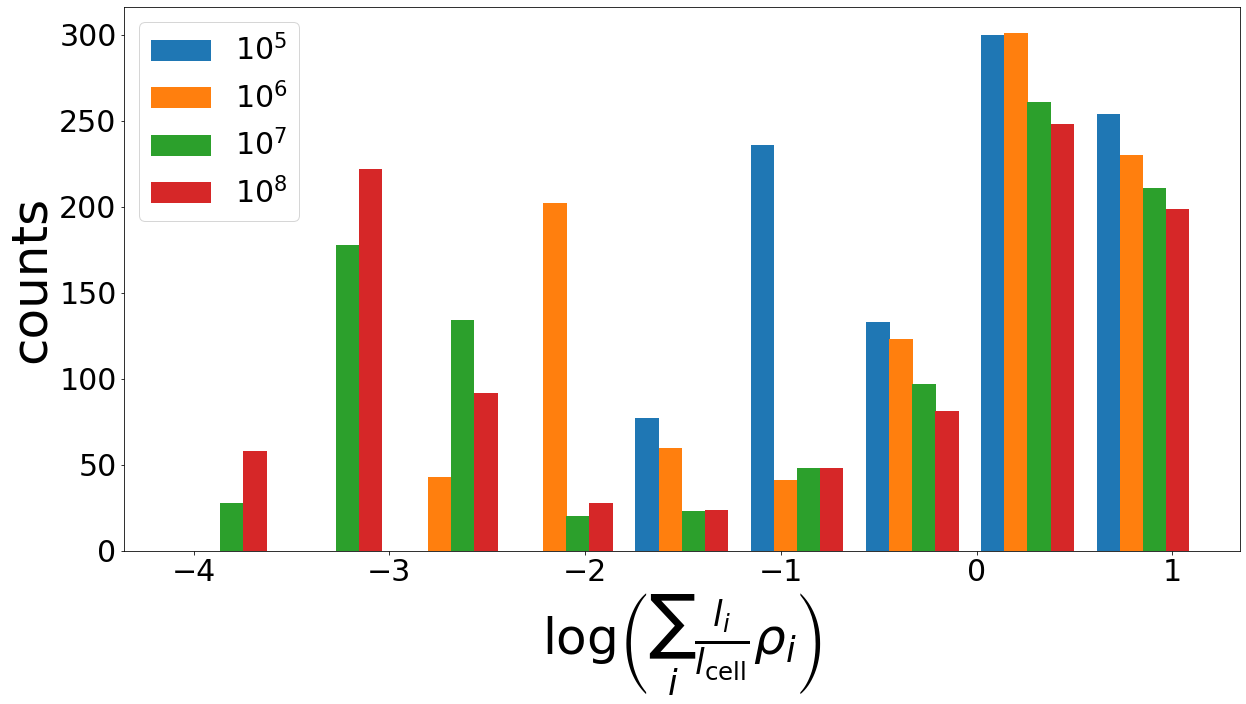

In [301]:
tick_label_size=30
labelsize=50
x_label = r'$\log \left( \sum_i \frac{l_i}{l_\mathrm{cell}} \rho_i \right)$'
y_label = 'counts'
values_1e5 = np.log10(dens_len_dict_1e5['HI'])
values_1e6 = np.log10(dens_len_dict_1e6['HI'])
values_1e7 = np.log10(dens_len_dict_1e7['HI'])
values_1e8 = np.log10(dens_len_dict_1e8['HI'])
data = np.zeros((len(values_1e5), 4))
data[:,0] = values_1e5
data[:,1] = values_1e6
data[:,2] = values_1e7
data[:,3] = values_1e8
labels = ['$10^5$', '$10^6$', '$10^7$', '$10^8$']
bins = np.linspace(data.min(),data.max(), 10)
plt.hist(data, bins=bins, width = 0.12, label=labels)
plt.rcParams["figure.figsize"] = (20,10)
plt.rc('xtick', labelsize=tick_label_size) 
plt.rc('ytick', labelsize=tick_label_size) 
plt.legend(fontsize=30)
plt.xlabel(x_label, fontsize=labelsize)
plt.ylabel(y_label, fontsize=labelsize);

In [330]:
def get_density_maps_mod(halo_id, redshift, conf, ic_num='00'):
    path_out = get_simulation_path(halo_id=halo_id, redshift=redshift, conf=conf)
    sim = get_sim(halo_id, redshift, conf)
    ic = sim.ICs[ic_num]
    
    halo = crashMemMap(path_out, 'all')
    density_maps = {}
    
    HI_map = get_H_map(halo)
    HeI_map = get_He_map(halo)
    HeII_map = np.zeros_like(halo[2])+halo[2]
    
#     HI_map[HI_map<1e-2] = 0.
#     HeI_map[HeI_map<1e-2] = 0.
#     HeII_map[HeII_map<1e-2] = 0.
    
    density_maps['HI'] = HI_map*ic.getHDensity()
    density_maps['HeI'] = HeI_map*ic.getHeDensity()
    density_maps['HeII'] = HeII_map*ic.getHeDensity()
    
    cell_size_cm = get_cell_size_cm(ic)
    return cell_size_cm, density_maps

In [307]:
test = np.array([1e-4, 3., 1e-2, 1e-1])
test[test<0.02]=0
test

array([0. , 3. , 0. , 0.1])

In [332]:
confs = ['single_source_1e5','single_source_1e6','single_source_1e7','single_source_1e8']
keys = ['1e5', '1e6', '1e7', '1e8']
dens_len_dict = {}
densities = {}
for i in range(4):
    np.random.seed(42)
    random.seed(42)
    lum, pos, spectra, sigma_cm2 = get_halo_sources(1029, 8, confs[i])
    cell_size_cm, densities[keys[i]] =  get_density_maps_mod(1029, 8, confs[i])
    radius = densities[keys[i]]['HI'].shape[0]/2
    halo_center = [radius, radius, radius]
    f_esc, per_freq, dens_len_dict[keys[i]] = calculate_source_esc(densities=densities[keys[i]], source_pos=pos[0], cross_sections=sigma_cm2, 
                                 luminosity=lum[0], spectrum=spectra[0], 
                                 cell_size=cell_size_cm, halo_radius=radius, halo_center=halo_center,
                                ray_number=1000, threshold=0.1)
    print(f_esc)
#print(per_freq)

1.7301999803565233e-06
0.007102948756221143
0.15115679032120705
0.20339577191753166


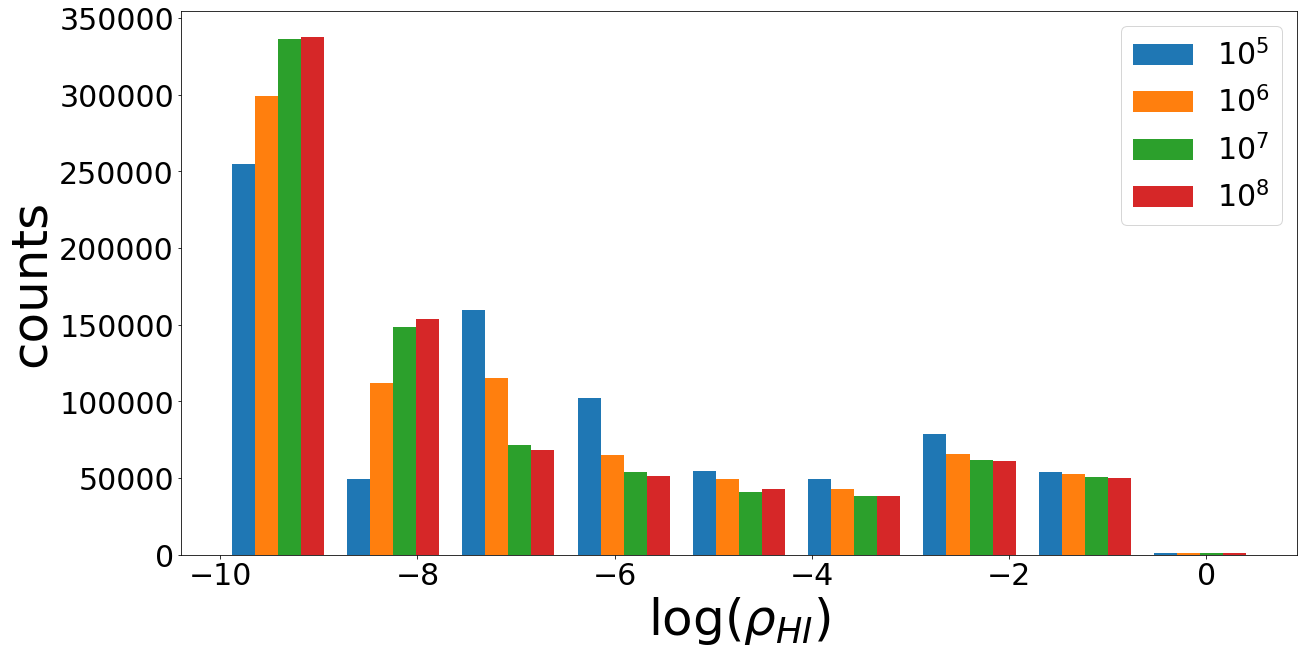

In [336]:
tick_label_size=30
labelsize=50
x_label = r'$\log(\rho_{HI})$'
y_label = 'counts'
values_1e5 = np.log10(densities['1e5']['HI'].flatten()+1e-10)
values_1e6 = np.log10(densities['1e6']['HI'].flatten()+1e-10)
values_1e7 = np.log10(densities['1e7']['HI'].flatten()+1e-10)
values_1e8 = np.log10(densities['1e8']['HI'].flatten()+1e-10)
data = np.zeros((len(values_1e5), 4))
data[:,0] = values_1e5
data[:,1] = values_1e6
data[:,2] = values_1e7
data[:,3] = values_1e8
labels = ['$10^5$', '$10^6$', '$10^7$', '$10^8$']
bins = np.linspace(data.min(),data.max(), 10)
plt.hist(data, bins=bins, label=labels)
plt.rcParams["figure.figsize"] = (20,10)
plt.rc('xtick', labelsize=tick_label_size) 
plt.rc('ytick', labelsize=tick_label_size) 
plt.legend(fontsize=30)
plt.xlabel(x_label, fontsize=labelsize)
plt.ylabel(y_label, fontsize=labelsize);

0.0
122031809.57020433
202014.81655008547


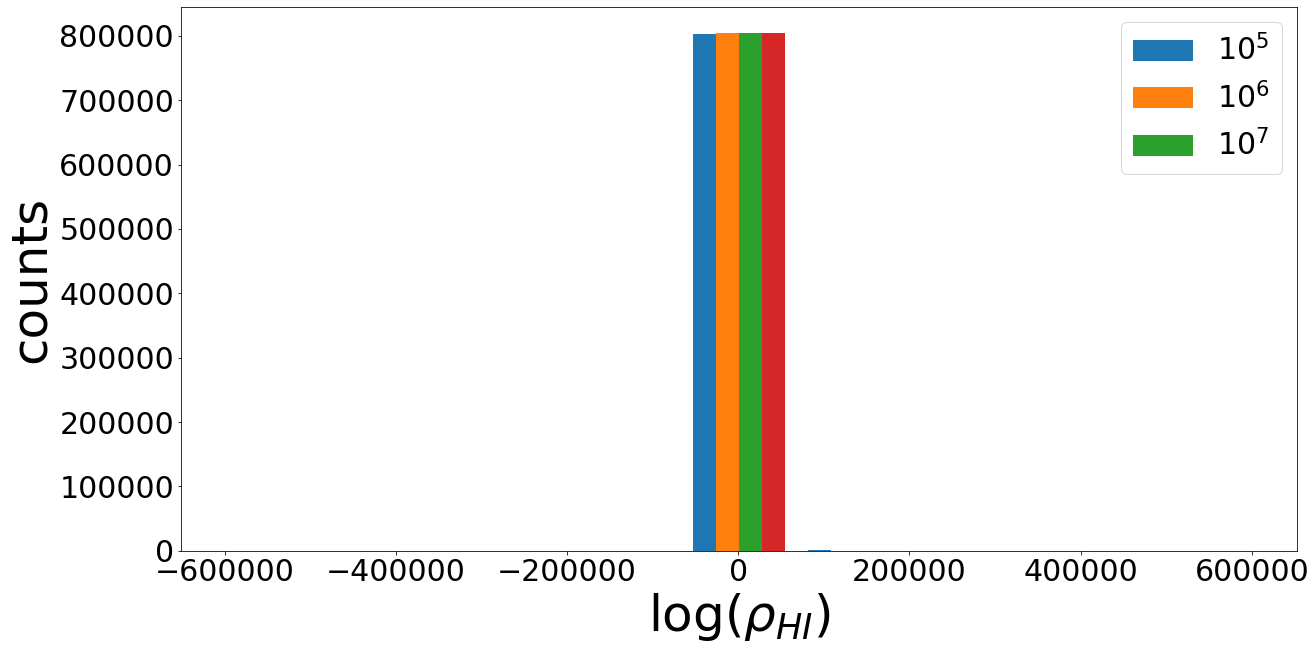

In [342]:
tick_label_size=30
labelsize=50
x_label = r'$\log(\rho_{HI})$'
y_label = 'counts'
values_1e5 = densities['1e5']['HI'].flatten()+1e-10
values_1e6 = densities['1e6']['HI'].flatten()+1e-10
values_1e7 = densities['1e7']['HI'].flatten()+1e-10
values_1e8 = densities['1e8']['HI'].flatten()+1e-10
data = np.zeros((len(values_1e5), 4))
data[:,0] = values_1e5/values_1e8
data[:,1] = values_1e6/values_1e8
data[:,2] = values_1e7/values_1e8
labels = ['$10^5$', '$10^6$', '$10^7$']
bins = np.linspace(data.mean()-3*data.std(),data.mean()+3*data.std(), 10)
print(data.min())
print(data.max())
print(data.std())
plt.hist(data, bins=bins, label=labels)
plt.rcParams["figure.figsize"] = (20,10)
plt.rc('xtick', labelsize=tick_label_size) 
plt.rc('ytick', labelsize=tick_label_size) 
plt.legend(fontsize=30)
plt.xlabel(x_label, fontsize=labelsize)
plt.ylabel(y_label, fontsize=labelsize);

In [558]:
conf = 'stroemgren_1e7'
path_out = get_simulation_path(halo_id=1029, redshift=8, conf=conf)
sim = get_sim(halo_id=1029, redshift=8, conf=conf)
ic = sim.ICs['00']

halo = crashMemMap(path_out, 'all')
density_maps = {}

cell_size_cm = get_cell_size_cm(ic)

In [559]:
cell_size_cm

3.174958576609364e+21

In [555]:
test_path = f'/freya/ptmp/mpa/mglatzle/TNG_f_esc/stroemgren_1e8/run/L35n2160TNG/sn008/g1029'
test = Sim(test_path)

In [560]:
ic.info['boxdimension']['cMpc']*3.086e+24

3.175290324e+23

In [576]:
cell_size_cm

3.174958576609364e+21

In [455]:
cell_size_cm[1]*96

0.011785679309308017

In [541]:
def stroemgren_rad_from_ion(boxsize, ionfrac):
    return (3*(boxsize)**3*ionfrac/(4*np.pi))**(1/3)

In [575]:
stroemgren_rad_from_ion(boxsize=ic.info['boxdimension']['cMpc']*3.086e+24, ionfrac=0.0074)

3.838525913076637e+22

In [569]:
def stroemgren_rad(density, temperature, luminosity):
    beta =2.6e-13
    radius = (3/(4*np.pi)*luminosity/(density**2*beta))**(1/3)
    return radius

In [587]:
print(stroemgren_rad(0.01, 10000, 1e49)/3.08567758128E+18)

1462.0496990226234


In [578]:
85*3.08567758128E+18

2.622825944088e+20

In [528]:
1.0753265463381883e+22/3.969112905e+20

27.0923647695577

In [ ]:
1.6357282950983633e-06
0.007102948756221143
0.15115679032120705
0.20339577191753166


In [302]:
np.average(values_1e5)
np.average(values_1e6)
np.average(values_1e7)
np.average(values_1e8)

-0.08372399022235277

-0.4198518397854866

-0.9534110897388075

-1.1452319338334251

In [130]:
sigma_cm2[sigma_cm2.keys()[0]]

TypeError: 'dict_keys' object is not subscriptable

In [126]:
for key in densities.keys():
    print(densities[key].shape)
    print(sigma_cm2[key].shape)

(93, 93, 93)
(65,)
(93, 93, 93)
(65,)
(93, 93, 93)
(65,)


In [981]:
print(np.linalg.norm(np.array(source_pos_1)-np.array(end_pos_1)))

53.150729063673246


In [985]:
np.exp(-53.1507*0.018325)

0.37757480253955256

In [978]:
dens[10,90,30]

0.0183258146374831

In [854]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

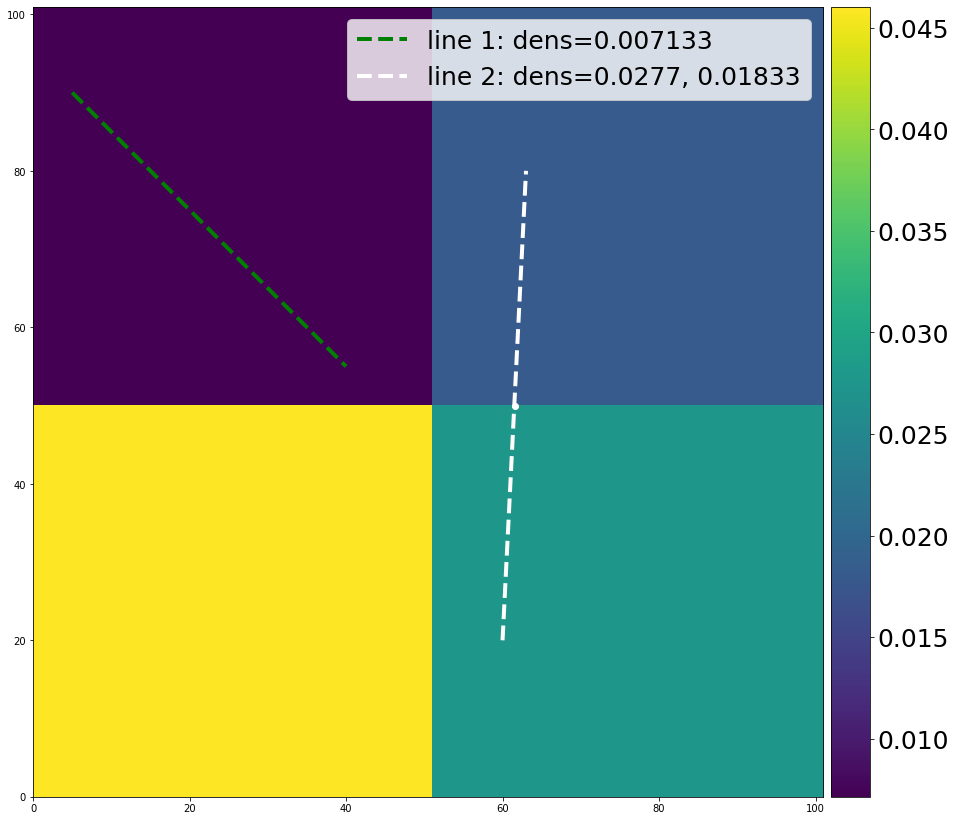

In [1011]:
f, ax = plt.subplots(1, 1)
ax.imshow(dens[:, :, 30], extent=[0, 101, 0, 101])
x = np.arange(5,41)
ax.plot(x, 95-x, '--', linewidth=4, color='green', label='line 1: dens=0.007133')
x_new = np.arange(1,5)
ax.plot(x_new+59, x_new*20, '--', linewidth=4, color='white',  label='line 2: dens=0.0277, 0.01833')
ax.scatter(61.55, 50, color='white')
plt.legend(fontsize=25)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
cbar.ax.tick_params(labelsize=25);

Line 1: Origin (45, 55, 30)  End (5, 90, 30) l=53.1507 <br>
Line 2: Origin (60, 20, 30)  End (63, 80, 30) Crossing (61.55, 51, 30)

In [972]:
np.linalg.norm(np.array([5,90,30])-np.array([45, 55, 30]))

53.150729063673246

In [894]:
import numba

In [896]:
print(numba.__version__)

0.50.1


In [890]:
1231/20

61.55

In [876]:
dens[60, 30, 30]

0.04605170185988091

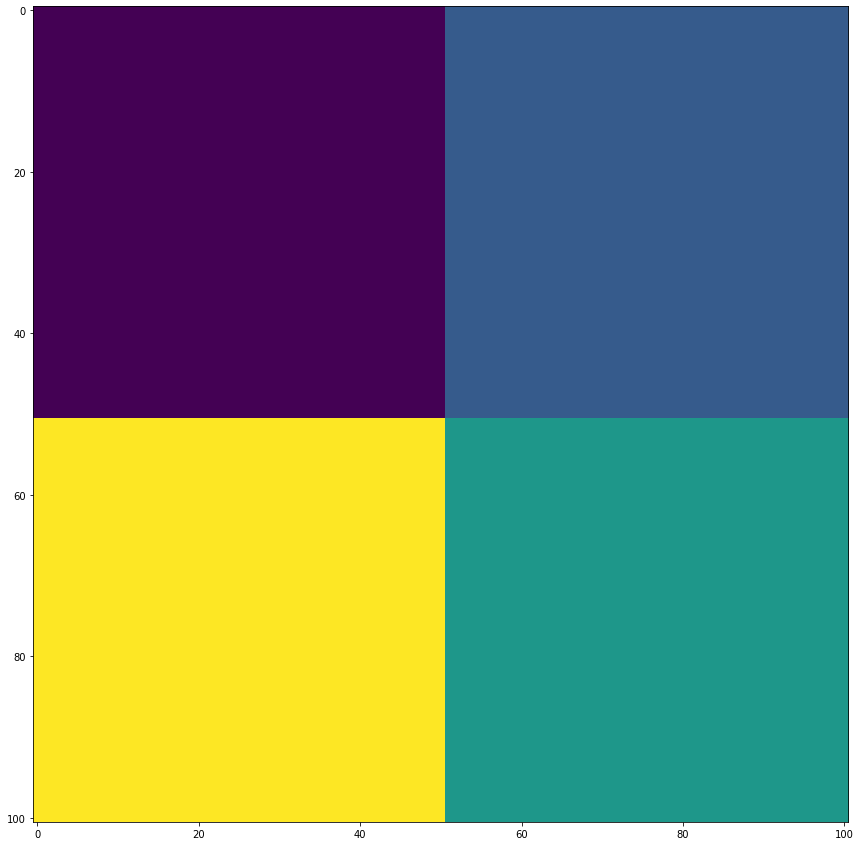

In [830]:
plt.imshow(dens[:, :, 30])

In [ ]:
# 0.001 f_esc approx 0.25
[0.25217215] #100
[0.25071369] #300
[0.25643407] #500
[0.25553836] #1000
[0.25299194] #3000

In [ ]:
# 0.001
0.051373368061154 #300
0.0501500954588 # 100
0.049029877 # 10
0.05142294 # 500
0.05057294542862962 #1000

In [ ]:
# 0.0001
[0.05052141] 300
[0.05020444] 500
[0.05038568] 1000
[0.05100351] 100
[0.04883727] 10

In [ ]:
[0.05100922]
[0.05017241]

In [ ]:
[0.05066671]
[0.05146236]
[0.0524]

In [ ]:
[0.05117511]

In [ ]:
[0.04914679]
[0.0483]

In [ ]:
[0.05223825]
[0.05004899]

In [755]:
# Test 3: per_freq=[0.05, 0.0024, 0.001] f_esc=0.015285714285714288
cell_size = 1
sigma = 1
dens = -np.log(0.1)/50*np.ones((101,101,101))
dens[50:, :, :] = 1
r_halo = 50
luminosity = 1
source_pos = [50.5,50.5,50.5]
halo_center = [50.5,50.5,50.5]
spectrum = np.array([1, 0.5, 2])
cross_section = np.array([1, 2, 3])
f_esc, per_freq = calculate_source_esc(densities=dens, source_pos=source_pos, cross_sections=cross_section, 
                             luminosity=luminosity, spectrum=spectrum, 
                             cell_size=1, halo_radius=r_halo, halo_center=halo_center,
                             ray_number=100, threshold=0.0001)
print(f_esc)
print(per_freq)

0.005115000362238779
[1.74133790e-02 4.07161047e-04 8.19612502e-05]


In [749]:
dens = -np.log(0.1)/50*np.ones((101,101,101))
dens[50:, :, :] = 1

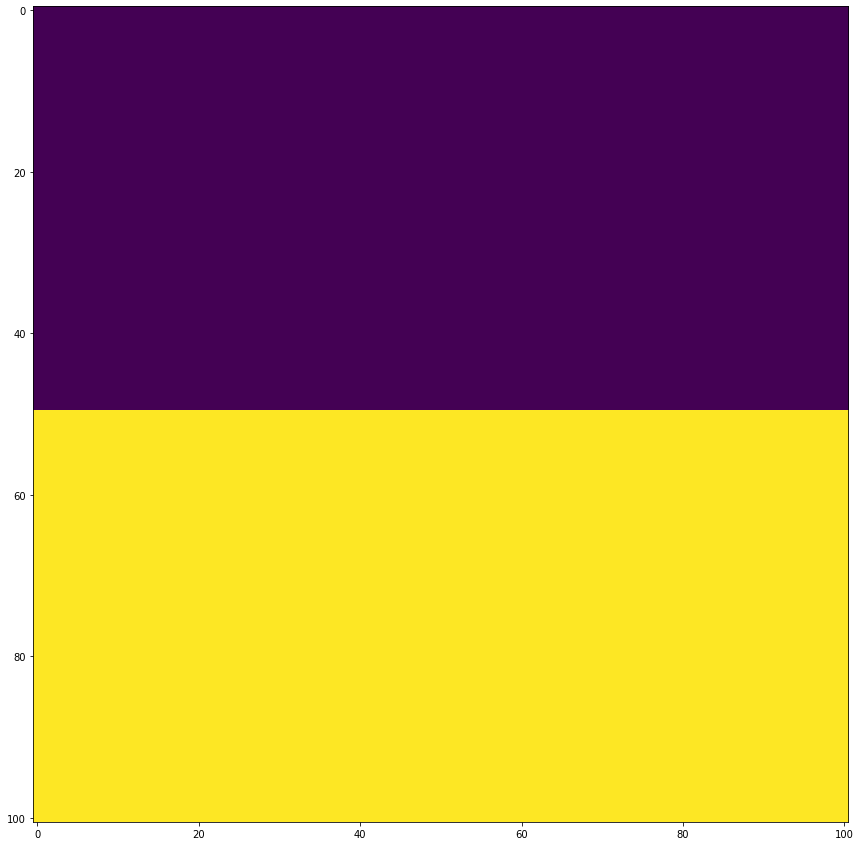

In [751]:
plt.imshow(dens[:, :, 30])

In [731]:
np.array([1, 2, 3])*np.log(0.1)

array([-2.30258509, -4.60517019, -6.90775528])

In [738]:
0.1**(np.array([1,2,3]))

array([0.1  , 0.01 , 0.001])

In [734]:
np.exp(-np.array([1,2,3]))

array([0.36787944, 0.13533528, 0.04978707])

In [739]:
np.sum(np.array([0.1, 0.01, 0.001])*np.array([1, 0.5, 2]))/np.sum(np.array([1, 0.5, 2]))

0.030571428571428576

In [698]:
np.exp(-2)*0.1
np.exp(-3)*0.1

0.013533528323661271

0.004978706836786395

In [681]:
dens[50, 50, 50]

0.04605170185988091

In [623]:
cross_sections = np.array([2,3,4])
lengths = np.array([0.1, 0.3, .7, 1.1, 0.4])
densities = np.array([0.5, 1, 4, 3, 1])

In [625]:
densities*(1.-np.exp(-1*lengths))

array([0.04758129, 0.25918178, 2.01365878, 2.00138675, 0.32967995])

In [615]:
get_optical_depth(densities, lengths, cross_sections, cell_size=5)

array([13.7 , 20.55, 27.4 ])

In [604]:
import time

In [607]:
start_time = time.time()
source_coordinates = [200.5, 200.5, 400.5]
sphere_center = [500,500,500]
test_sphere = Sphere(sphere_center, 500)

for j in range(1000):
    test_line = get_random_line(source_coordinates)
    sphere_point = get_point_on_sphere(test_line, test_sphere)
    crossing_points = get_crossing_points(source_coordinates, sphere_point, test_line)
    sorted_crossing_points = sort_crossing_points(source_coordinates, crossing_points)
    coord_length = cell_coordinates_with_legths(source_coordinates, sphere_point, sorted_crossing_points)
print(time.time()-start_time())
#     for i in range(len(coord_length)-1):
#         increase = np.linalg.norm(coord_length[i+1][0]-coord_length[i][0])
#         if (increase > 1.001) or (increase < 0.999):
#             print('='*50)          
#             print(coord_length[i][0])
#             print(coord_length[i+1][0])
#             print('-'*40)
#             print(sorted_crossing_points[i][0])
#             print(sorted_crossing_points[i+1][0])
#             print('-'*40)
#             print(i)
#             print(len(coord_length))
#         previous = element[0]

TypeError: 'float' object is not callable

In [477]:
for element in sorted_crossing_points:
    print(element[0])

[20.30948515 20.84044396 31.        ]
[20.22019646 21.         31.23433524]
[20.         21.39348406 31.81223366]
[19.92845545 21.52133189 32.        ]
[19.66058939 22.         32.70300573]
[19.54742575 22.20221981 33.        ]
[19.16639605 22.88310774 34.        ]
[19.10098231 23.         34.17167621]
[19.         23.18045217 34.43670099]
[18.78536635 23.56399567 35.        ]
[18.54137524 24.         35.6403467 ]
[18.40433665 24.24488359 36.        ]
[18.02330695 24.92577152 37.        ]
[18.         24.96742029 37.06116832]
[17.98176816 25.         37.10901718]
[17.64227725 25.60665944 38.        ]
[17.42216109 26.         38.57768767]
[17.26124755 26.28754737 39.        ]
[17.         26.7543884  39.68563565]
[16.88021784 26.96843529 40.        ]
[16.86255401 27.         40.04635815]
[16.49918814 27.64932322 41.        ]
[16.30294694 28.         41.51502864]
[16.11815844 28.33021114 42.        ]
[16.         28.54135652 42.31010298]
[15.74333986 29.         42.98369912]
[15.73712874

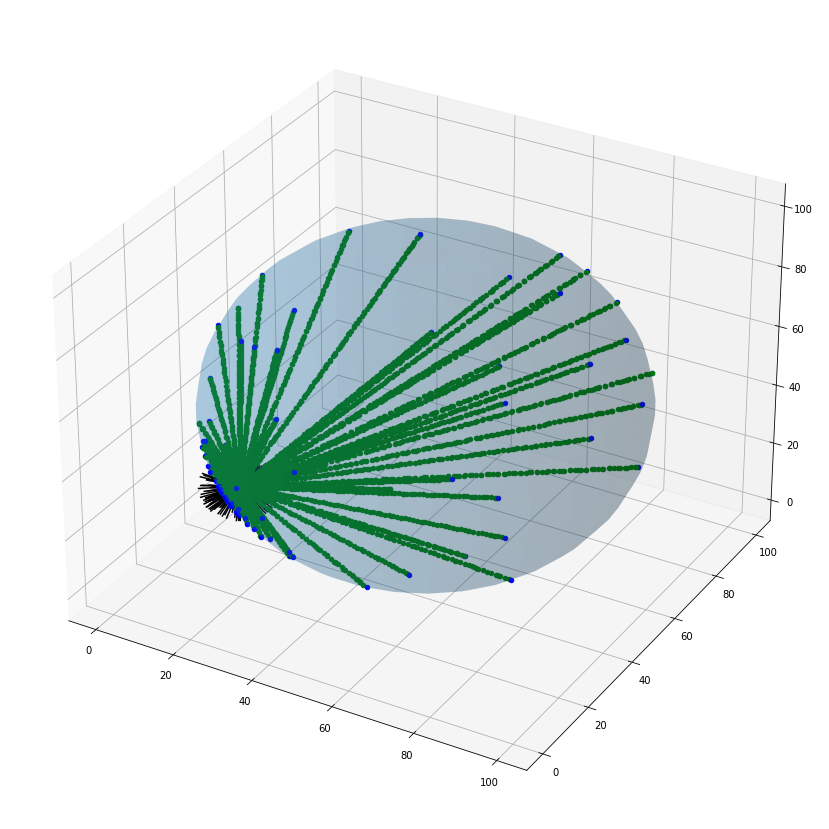

In [460]:
source_coordinates = [20.5, 20.5, 30.5]
sphere_center = [50,50,50]
test_sphere = Sphere(sphere_center, 50)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
test_sphere.plot_3d(ax, alpha=0.2)
for i in range(100):
    test_line = get_random_line(source_coordinates)
    sphere_point = get_point_on_sphere(test_line, test_sphere)
    crossing_points = get_crossing_points(source_coordinates, sphere_point, test_line)
    sorted_crossing_points = sort_crossing_points(source_coordinates, crossing_points)

    test_line.plot_3d(ax, t_1=-9, t_2=9, c='k')
    point = Point(source_coordinates)
    point.plot_3d(ax, c='r')
    sphere_point.plot_3d(ax, c='b')
    for element in sorted_crossing_points:
        point = Point(element[0])
        point.plot_3d(ax, c='g')

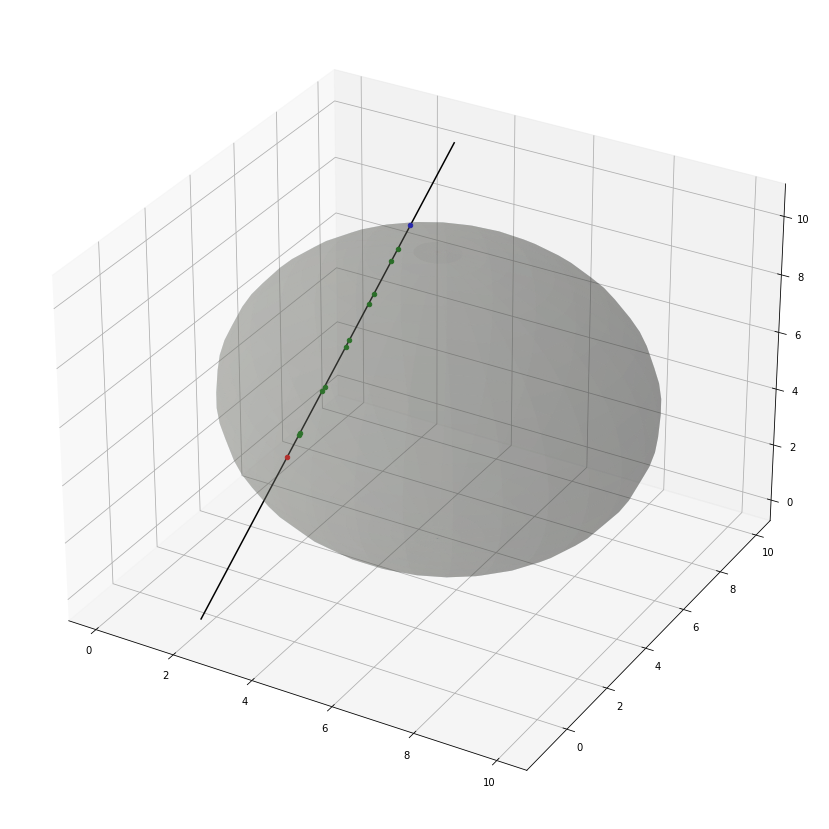

In [377]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
test_sphere.plot_3d(ax, alpha=0.2)

test_test = Sphere([5,5,5], 5)
test_test.plot_3d(ax, alpha=0.1)
test_line.plot_3d(ax, t_1=-5, t_2=10, c='k')
point = Point(source_coordinates)
point.plot_3d(ax, c='r')
sphere_point.plot_3d(ax, c='b')
for element in sorted_crossing_points:
    point = Point(element[0])
    point.plot_3d(ax, c='g')

In [ ]:
cell_coordinates_with_legths(source_coordinates, sphere_point, sorted_crossing_points)

In [251]:
for element in sorted_crossing_points:
    print(element[0])

[0.04868087 1.         1.19731667]
[0.         0.94606825 1.16466818]
[-0.24553021  0.67405429  1.        ]
[-0.8539574   0.          0.59195001]
[-1.         -0.16179526  0.49400455]
[-1.73659063 -0.97783714  0.        ]
[-1.75659567 -1.         -0.01341666]
[-2.         -1.26965877 -0.17665909]


In [246]:
sphere_point

Point([-2.41174672, -1.72581794, -0.45280264])

In [247]:
np.linalg.norm(sphere_point-source_coordinates)

4.764200713689995

<Figure size 1080x1080 with 0 Axes>

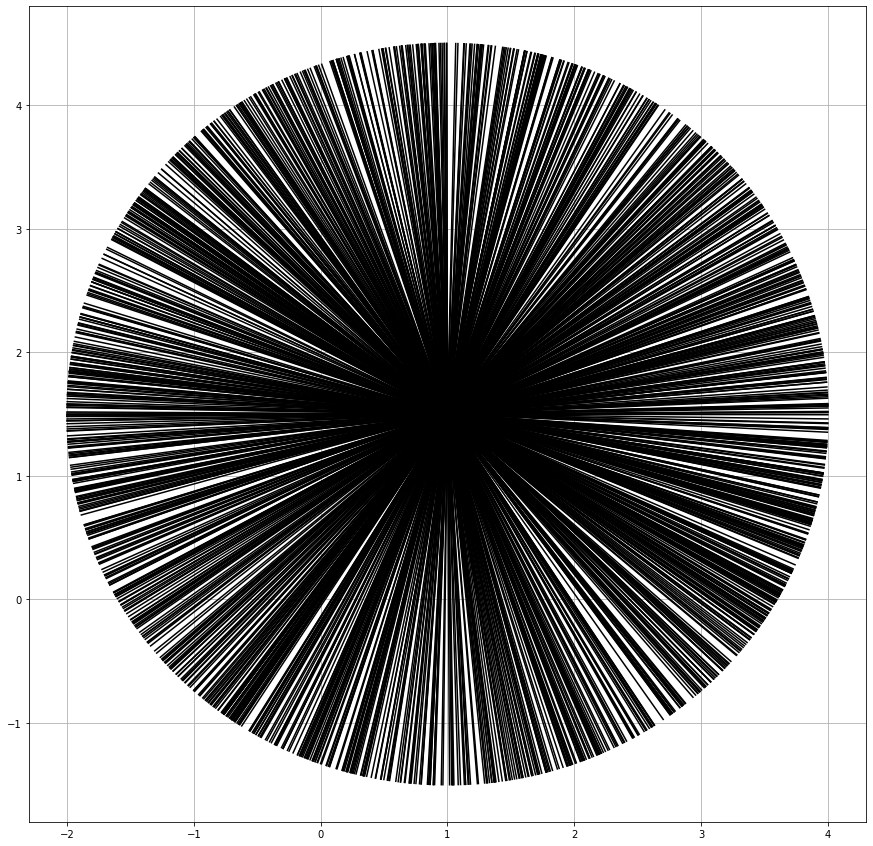

In [209]:
lines = []
source_coordinates = [1., 1.5]
fig = plt.figure()
_, ax = plt.subplots()
for i in range(1500):
    line = get_random_line_2d(source_coordinates)
    line.plot_2d(ax, t_1=0, t_2=3, c='k')
grid = ax.grid()

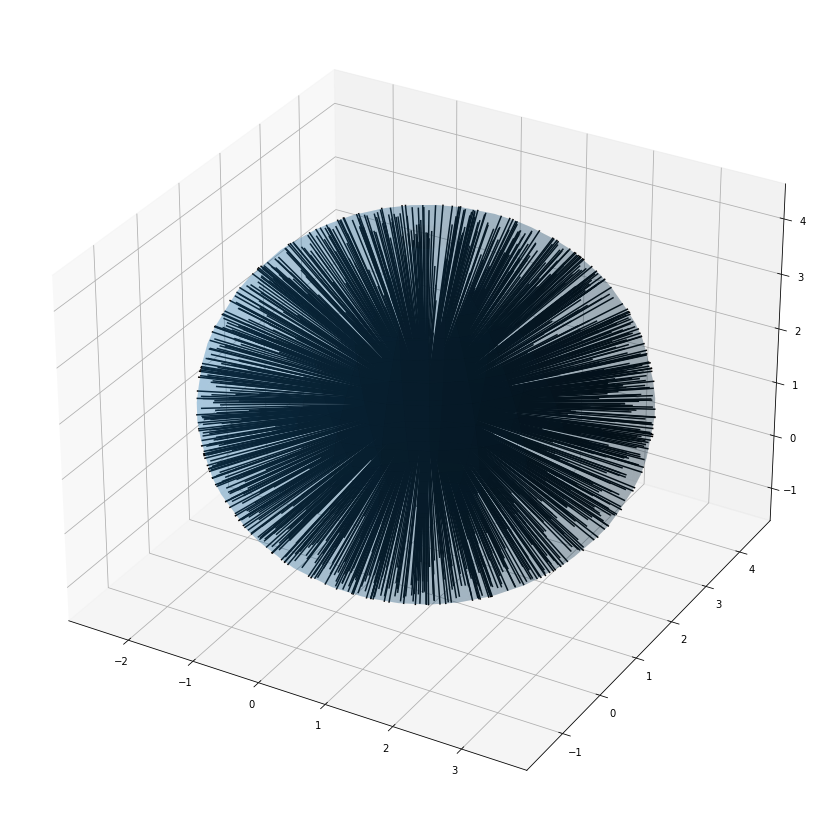

In [237]:
lines = []
source_coordinates = [0.5, 1.5, 1.5]
fig = plt.figure()
test_sphere = Sphere(source_coordinates, 3)
get_point_on_sphere(line, sphere)

ax = fig.add_subplot(111, projection='3d')
for i in range(1500):
    line = get_random_line(source_coordinates)
    line.plot_3d(ax, t_1=0, t_2=3, c='k')
test_sphere.plot_3d(ax, alpha=0.2)

In [107]:
circle = Circle([0,0], 3)
sphere = Sphere([0,0,0], 3)
line = Line(center, center+np.array([np.sin(theta), np.cos(theta)]))

direction_3d = np.array([np.sin(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), np.cos(theta)])
line_3d = Line(center_3d, center_3d+direction_3d)

In [108]:
point_a_3d, point_b_3d = sphere.intersect_line(line_3d)

In [144]:
point_a_3d, point_b_3d = sphere.intersect_line(line_3d)
sphere_point = random.sample([point_a_3d, point_b_3d], 1)[0]

In [147]:
sphere = Sphere([0,0,0], 3)
direction_3d = np.array([np.sin(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), np.cos(theta)])
line_3d = Line(center_3d, center_3d+direction_3d)

center_ar = np.array(center_3d)
sphere_point_ar = np.array(sphere_point)
#np.floor(np.array(end_point))
crossing_points = []
for i in range(3):
    if center_ar[i]<sphere_point_ar[i]:
        start = center_ar[i]
        end = sphere_point_ar[i]
    else:
        start = sphere_point_ar[i]
        end = center_ar[i]
        
    coordinate = np.ceil(start)
    while coordinate<end:
        if i == 0:
            plane = Plane(point=[coordinate, 0, 0], normal=[1, 0, 0])
        elif i == 1:
            plane = Plane(point=[0, coordinate, 0], normal=[0, 1, 0])
        elif i == 2:
            plane = Plane(point=[0, 0, coordinate], normal=[0, 0, 1])
        else:
            raise ValueError('Dimension has to be 3')
        crossing_points.append(plane.intersect_line(line_3d))
        coordinate += 1

In [148]:
crossing_points

[Point([-2.        , -1.26965877, -0.17665909]),
 Point([-1.        , -0.16179526,  0.49400455]),
 Point([0.        , 0.94606825, 1.16466818]),
 Point([-1.75659567, -1.        , -0.01341666]),
 Point([-0.8539574 ,  0.        ,  0.59195001]),
 Point([0.04868087, 1.        , 1.19731667]),
 Point([-1.73659063, -0.97783714,  0.        ]),
 Point([-0.24553021,  0.67405429,  1.        ])]

In [142]:
np.array(sphere_point)

array([ 1.52796308, -2.58172981])

In [146]:
center_ar[0]
sphere_point_ar[0]

0.5

-2.411746715741647

(-0.8017443260175141, 1.801744326017514, -3.668832157070983, 6.668832157070983)

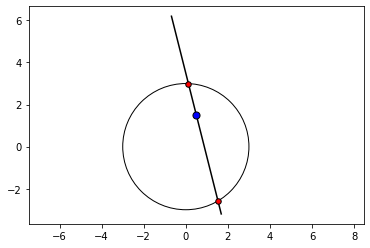

In [115]:
_, ax = plot_2d(
    #circle.plotter(fill=False),
    circle.plotter(fill=False),
    line.plotter(t_1=-6, t_2=6, c='k'),
    point_a.plotter(c='r', s=30, edgecolor='k', zorder=3),
    point_b.plotter(c='r', s=30, edgecolor='k', zorder=3),
    center.plotter(c='b', s=50, edgecolor='k', zorder=3),
)
ax.axis('equal')

In [155]:
plt.rcParams["figure.figsize"] = (15,15)

(<Figure size 1080x1080 with 1 Axes>, <Axes3DSubplot:>)

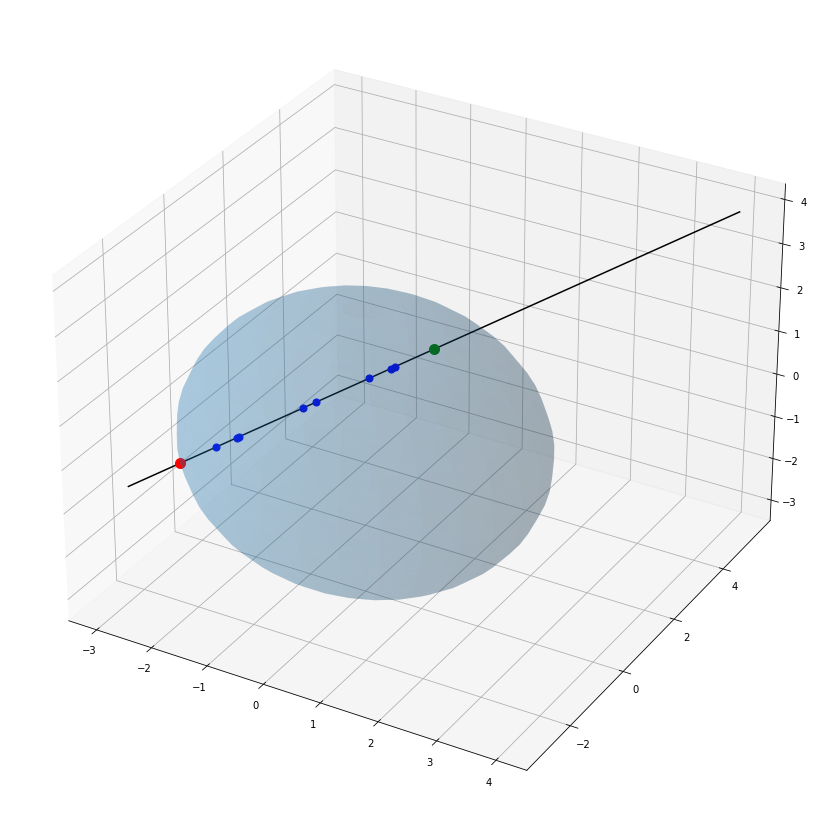

In [160]:
plot_3d(
    line_3d.plotter(t_1=-3,t_2=3, c='k'),
    sphere.plotter(alpha=0.2),
    point_a_3d.plotter(c='r', s=100),
    center_3d.plotter(c='g', s=100),
    Point([-2., -1.26965877, -0.17665909]).plotter(c='b', s=50),
    Point([-1.        , -0.16179526,  0.49400455]).plotter(c='b', s=50),
    Point([0.        , 0.94606825, 1.16466818]).plotter(c='b', s=50),
    Point([-1.75659567, -1.        , -0.01341666]).plotter(c='b', s=50),
    Point([-0.8539574 ,  0.        ,  0.59195001]).plotter(c='b', s=50),
    Point([0.04868087, 1.        , 1.19731667]).plotter(c='b', s=50),
    Point([-1.73659063, -0.97783714,  0.        ]).plotter(c='b', s=50),
    Point([-0.24553021,  0.67405429,  1.        ]).plotter(c='b', s=50)
    )